# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [1]:
# libraries
import torch
import random
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils
import BAAnet

### Process Endovis 2018 Dataset

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (160, 128)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9332088..3.38058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9169153..3.3345873].


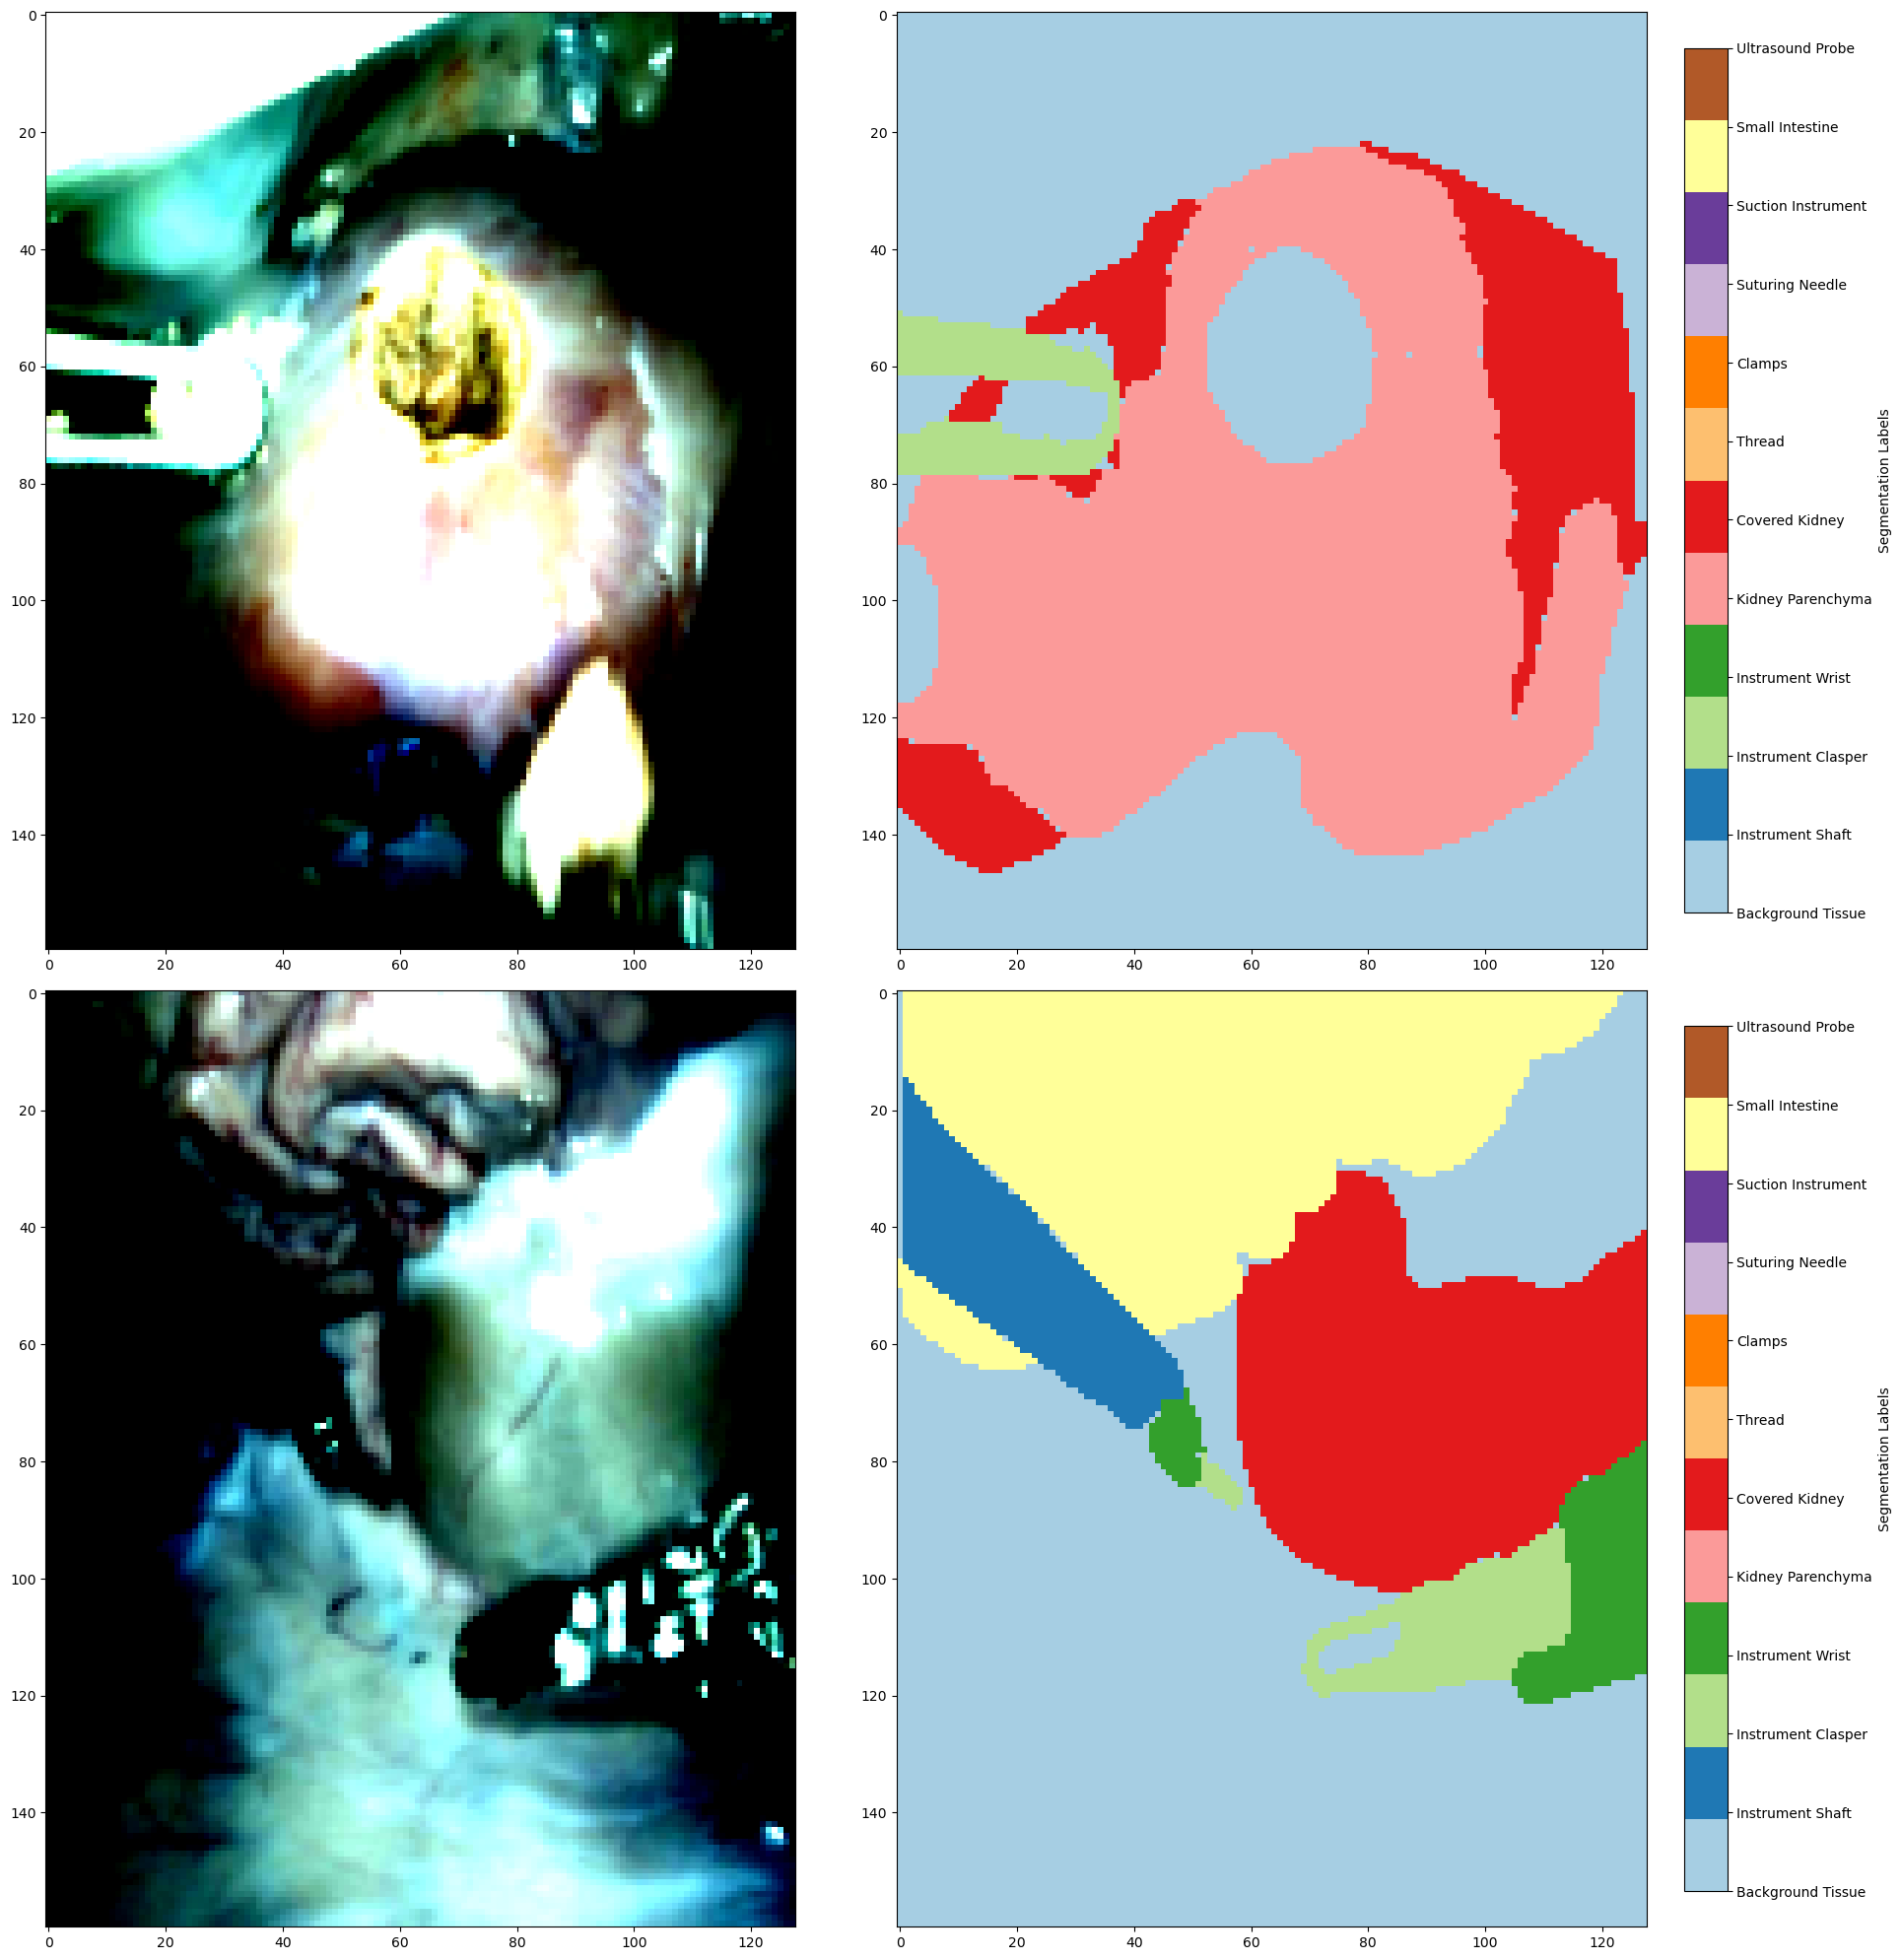

In [2]:
# get dataloaders and display test images
batch_size = 8
reduce_factor = 8 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

n = 2
cmap = plt.get_cmap('Paired',12)
cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
               "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]


fig, axes = plt.subplots(n, 2, figsize=(20, 20))
for i in range(n):  # Flatten the 2D array of axes
    axes[i,0].imshow(images[i].permute(1, 2, 0))  
    #axes[i,1].imshow(labels[i].permute(1, 2, 0))
    label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
    im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
    # colorbar settings
    cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
    cbar.set_label("Segmentation Labels", fontsize=10)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)

plt.tight_layout()
plt.show()

In [ ]:
# check encoder and BBA
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
label = labels[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,160]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model = BAAnet.BAANet()
y1,y2,y3,y4 = model(input)
print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model_BBA = BAAnet.BAANet_BAA_Only()
out = model_BBA(input)
print()
print("BAA_Only:", out.shape)

## Create Model and Hyperparameters


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 5
lr = 1e-4

model = BAAnet.BAANet_BAA_Only().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # learning rate scheduler

c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for i in range(epochs):
    TrainingUtils.train(val_dataloader, model, criterion, optimizer, scheduler, i+1, device)

In [4]:
m_dice, m_iou = TrainingUtils.test(model, train_dataloader, device)
print(f"Mean DICE Score: {m_dice}")
print(f"Mean IoU Score: {m_iou}")

205it [02:55,  1.17it/s]

Mean DICE Score: 0.4481997130429055
Mean IoU Score: 0.4476381347322447
